In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
coursework = '/content/drive/MyDrive/ColabNotebooks/Coursework/data'
os.makedirs(coursework, exist_ok=True)


In [ ]:
import pandas as pd
#getting all the needed csvs
prem = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Coursework/data/premier_league.csv')
inflation = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Coursework/data/Inflation_by_Year.csv')
gdp = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Coursework/data/gdp_per_q.csv')
#data cleaning
prem.dropna(inplace=True)
prem = prem.drop(columns=["fee", "transfer_period","player_name","age","position","club_involved_name","league_name"])
prem = prem[prem["fee_cleaned"] > 0]
prem_spending = prem[prem['transfer_movement']=='in'].copy()
prem_income = prem[prem['transfer_movement']=='out'].copy()
newcolumns = {
    'Year':'year',
    'Inflation':'inflation'
}
inflation = inflation.rename(columns=newcolumns)
inflation = inflation[(inflation["year"] >= 1992) & (inflation["year"] <= 2021)].reset_index(drop=True)
inflation["CPI"] = 100.0
for i in range(1, len(inflation)):
  inflation.loc[i, "CPI"] = inflation.loc[i-1, "CPI"] * (1 + inflation.loc[i, "inflation"] / 100)
gdp = gdp.rename(columns = {'Unit':'year','%':'gdp'})
gdp["year"] = gdp["year"].str[:4].astype(int)
gdp = gdp[gdp['year']>=1992].reset_index()
gdp_avg = gdp.groupby("year")["gdp"].mean().reset_index()
gdp_avg.rename(columns={"gdp": "yearly_gdp"}, inplace=True)
#this is to get the merged dataset to be able to analyse - adding CPI and GDP to both income and spending
prem_spending["year"] = prem_spending["season"].str[:4].astype(int)
adjusted_prem_spending = prem_spending.merge(inflation, left_on="year", right_on="year", how="left")
latest_CPI = inflation["CPI"].max()
adjusted_prem_spending["fee_adjusted"] = adjusted_prem_spending["fee_cleaned"] * (latest_CPI / adjusted_prem_spending["CPI"])
adjusted_prem_spending = adjusted_prem_spending.merge(gdp_avg, left_on="year", right_on="year", how="left")
prem_income["year"] = prem_income["season"].str[:4].astype(int)
adjusted_prem_income = prem_income.merge(inflation, left_on="year", right_on="year", how="left")
adjusted_prem_income["fee_adjusted"] = adjusted_prem_income["fee_cleaned"] * (latest_CPI / adjusted_prem_income["CPI"])
adjusted_prem_income = adjusted_prem_income.merge(gdp_avg, left_on="year", right_on="year", how="left")
#creating dimensions of the dataframe to be able to plot specific graphs as shown in report
club_spending = adjusted_prem_spending.groupby(["season","club_name","yearly_gdp"])[["fee_adjusted","fee_cleaned"]].sum().reset_index()
club_income = adjusted_prem_income.groupby(["season","club_name"])[["fee_adjusted","fee_cleaned"]].sum().reset_index()
season_spending = club_spending.groupby(["season","yearly_gdp"])[["fee_adjusted","fee_cleaned"]].sum().reset_index()
average_spending = club_spending.groupby(["season","club_name"])[["fee_adjusted","fee_cleaned"]].mean().reset_index()
average_spending = average_spending.groupby("season")[["fee_adjusted","fee_cleaned"]].mean().reset_index()
average_spending["fee_cleaned"] = average_spending["fee_cleaned"]
average_spending["fee_adjusted"] = average_spending["fee_adjusted"]
max_spending = adjusted_prem_income.groupby("season")["fee_adjusted"].max().reset_index()
max_spending.rename(columns={"fee_adjusted": "max_spending"}, inplace=True)
#this is for the big six dimension
big_six = ["Manchester United", "Chelsea FC", "Arsenal FC", "Liverpool FC", "Manchester City", "Tottenham Hotspur"]
club_names = adjusted_prem_spending["club_name"].unique()
big_six_spending = club_spending[club_spending["club_name"].isin(big_six)].copy()
big_six_income = club_income[club_income["club_name"].isin(big_six)].copy()
spending_sum = big_six_spending.groupby("season")["fee_adjusted"].sum().reset_index()
income_sum = big_six_income.groupby("season")["fee_adjusted"].sum().reset_index()
big_six_transfers = spending_sum.merge(income_sum, on="season", how="left")
big_six_transfers.rename(columns={"fee_adjusted_x": "fee_adjusted_spending", "fee_adjusted_y": "fee_adjusted_income"}, inplace=True)


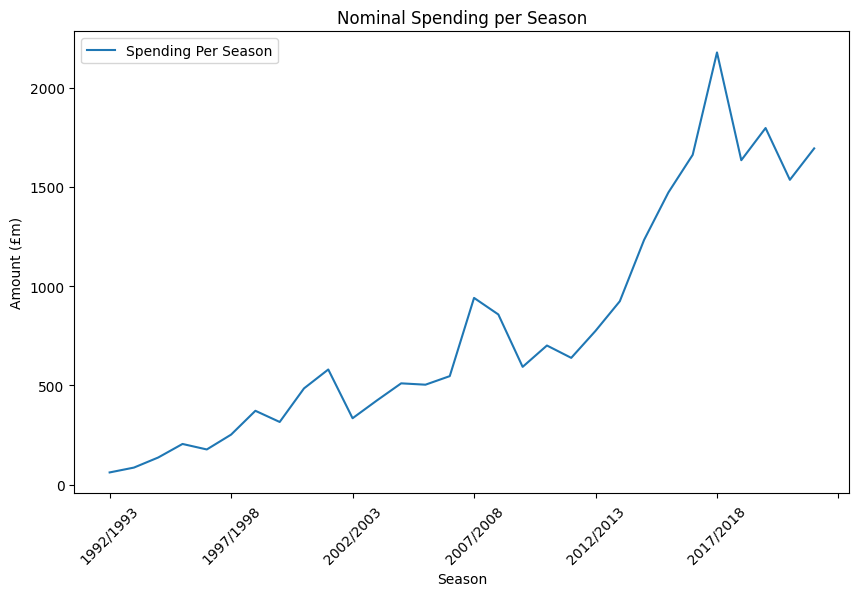

<Figure size 1600x600 with 0 Axes>

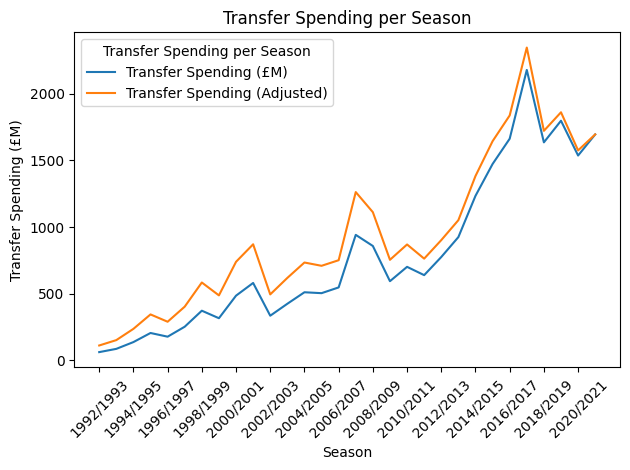

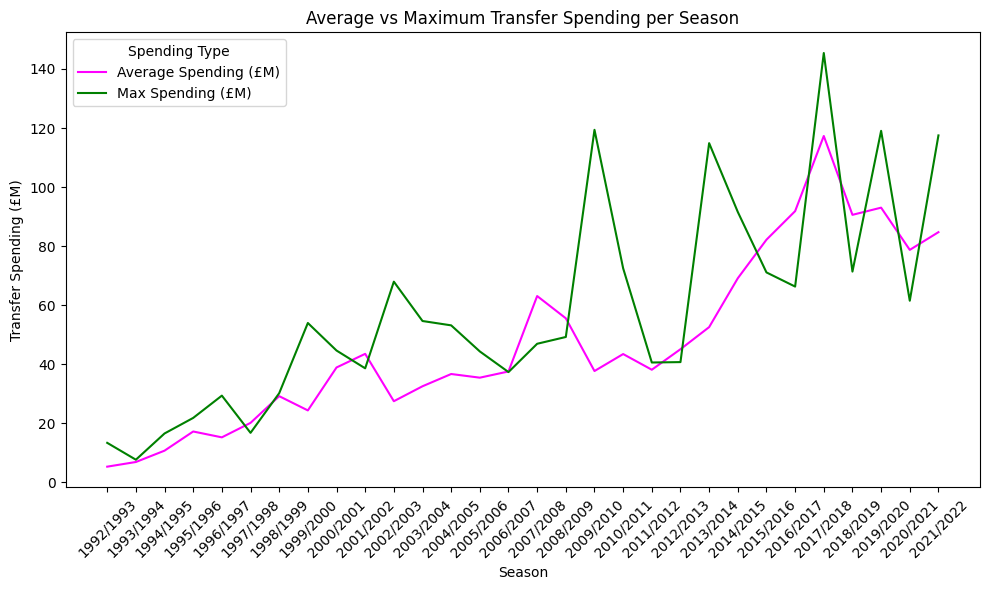

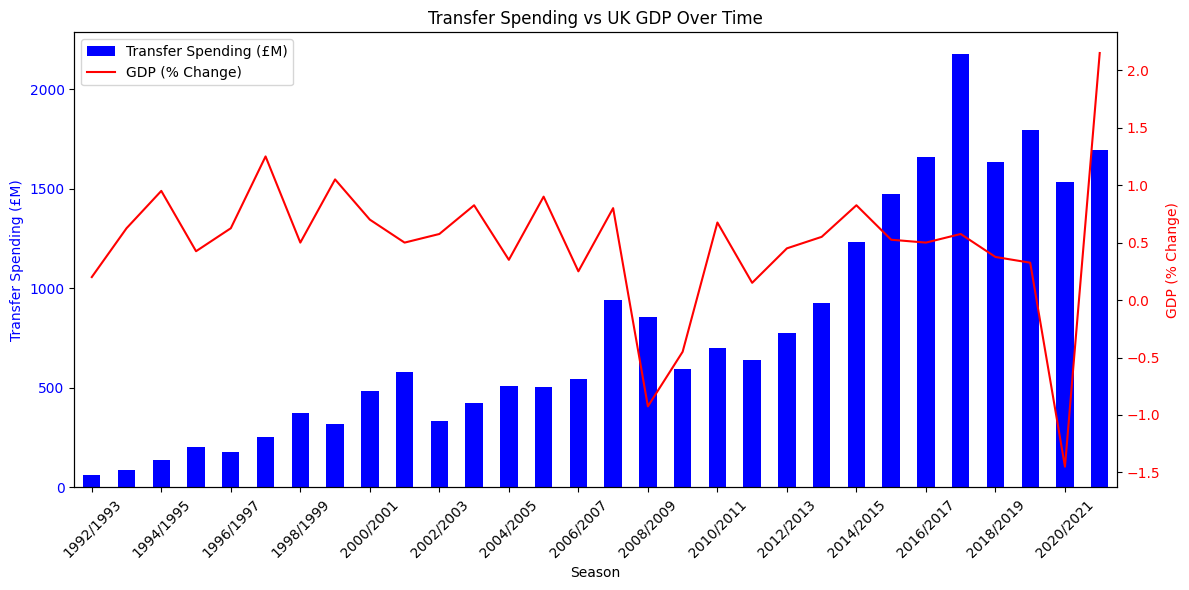

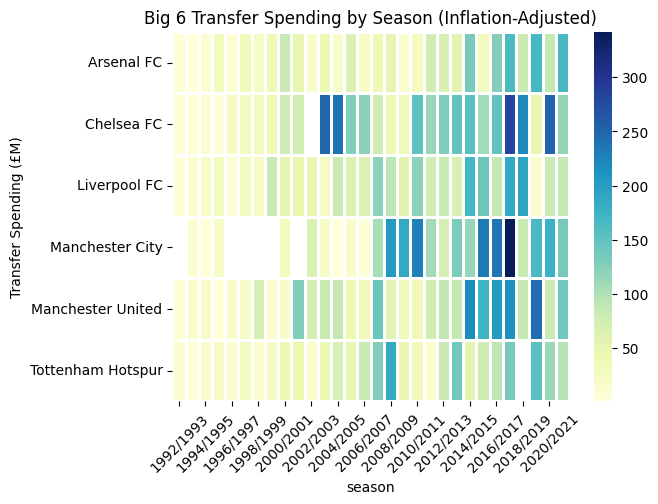

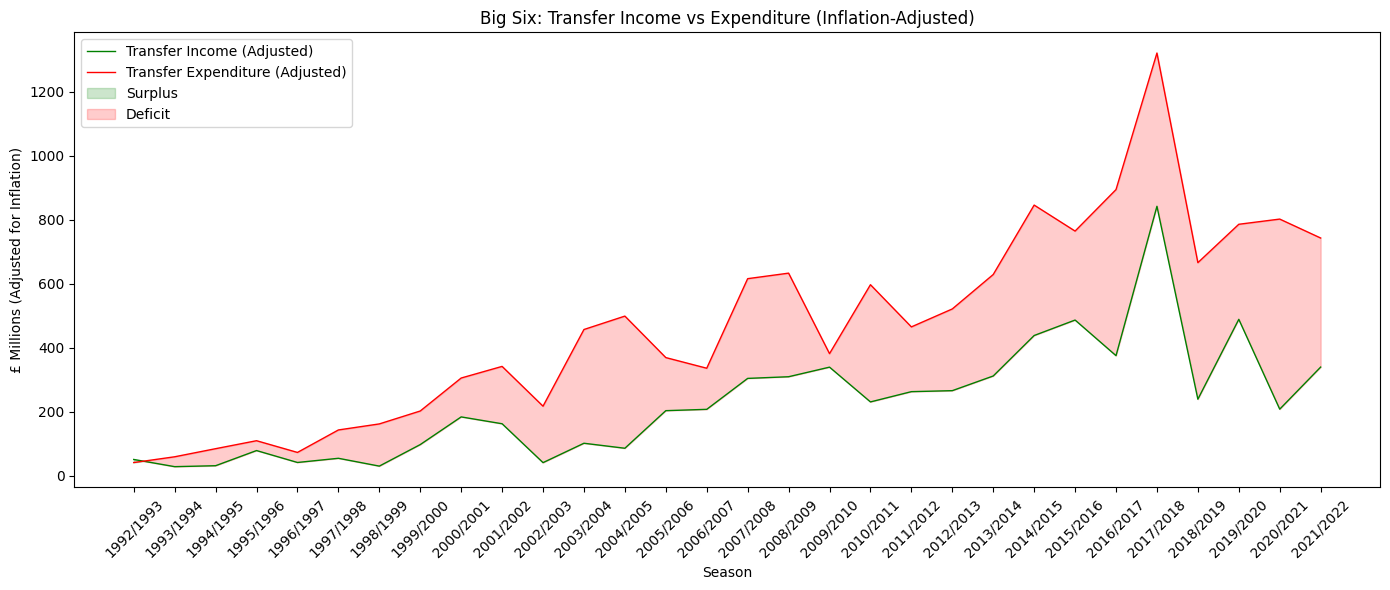

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
#now we are plotting each figure at a time
#figure 1
season_spending.plot(kind = 'line',x='season',y='fee_cleaned',figsize=(10, 6),label='Net Annual Spending',title='Nominal Spending per Season',xlabel='Season',ylabel='Amount (£m)')
plt.legend(['Spending Per Season'], loc='upper left')
plt.xticks(rotation=45)
plt.show()
#figure 2
plt.figure(figsize=(16, 6))
season_spending.plot(x='season', y=['fee_cleaned','fee_adjusted'], kind='line', label=['Transfer Spending (£M)', 'Transfer Spending (Adjusted)'], legend=True)
plt.xlabel('Season')
plt.ylabel('Transfer Spending (£M)')
plt.title('Transfer Spending per Season')
plt.xticks(ticks=range(0, len(average_spending), 2),
           labels=average_spending['season'][::2],
           rotation=45)
plt.legend(title="Transfer Spending per Season")
plt.tight_layout()
plt.show()
#figure 3 - i found the plt plot easier to plot two lines from different slices
plt.figure(figsize=(10, 6))
plt.plot(average_spending["season"], average_spending["fee_adjusted"], label="Average Spending (£M)", color="magenta")
plt.plot(max_spending["season"], max_spending["max_spending"], label="Max Spending (£M)", color="green")
plt.title("Average vs Maximum Transfer Spending per Season")
plt.xlabel("Season")
plt.ylabel("Transfer Spending (£M)")
plt.xticks(rotation=45)
plt.legend(title="Spending Type")
plt.tight_layout()
plt.show()
#figure 4 - my hardest plot in terms of getting the legend both on the left side. First, I set a subplot as ax1. Once plotting the data I wanted, I then used the twinx() function on ax1 to create ax2 to be able to plot on the same graph
#For the legend problem, I found I had to remove both before adding them so I used an if statment to remove them before adding the legends i wanted. the matplotlib(2025) website helped alot.
fig, ax1 = plt.subplots(figsize=(12, 6))
season_spending.plot(kind = 'bar', x='season', y='fee_cleaned', ax=ax1, color='blue', label='Transfer Spending (£M)')
ax1.set_xlabel('Season')
ax1.set_ylabel('Transfer Spending (£M)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(season_spending.index[::2])
ax1.set_xticklabels(season_spending['season'][::2].astype(str), rotation=45)
ax2 = ax1.twinx()
season_spending.plot(x='season', y='yearly_gdp', ax=ax2, color='red', label='GDP (% Change)')
ax2.set_ylabel('GDP (% Change)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.title('Transfer Spending vs UK GDP Over Time')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
if ax1.get_legend():
    ax1.get_legend().remove()
if ax2.get_legend():
    ax2.get_legend().remove()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
plt.tight_layout()
plt.show()
#figure 5 - found theres a lot more you can do on seaborn (2025), using a heatmap to present my analyse
pivot = big_six_spending.pivot(index="club_name", columns="season", values="fee_adjusted")
sns.heatmap(pivot, cmap="YlGnBu", linewidths=.8)
plt.title("Big 6 Transfer Spending by Season (Inflation-Adjusted)")
plt.xticks(rotation=45)
plt.ylabel('Transfer Spending (£M)')
plt.show()
#figure 6 - used subplot lessons from matplotlib(2025) to help not having to create a new net gain/loss column, using the fill_between() function to present the gain/loss in a innovative manner.
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(big_six_transfers['season'], big_six_transfers['fee_adjusted_income'], color="green", label="Transfer Income (Adjusted)", linewidth=1)
ax.plot(big_six_transfers['season'],big_six_transfers['fee_adjusted_spending'], color="red", label="Transfer Expenditure (Adjusted)", linewidth=1)
ax.fill_between(big_six_transfers['season'], big_six_transfers['fee_adjusted_income'],big_six_transfers['fee_adjusted_spending'], where=(big_six_transfers['fee_adjusted_income'] > big_six_transfers['fee_adjusted_spending']), interpolate=True, color="green", alpha=0.2, label="Surplus")
ax.fill_between(big_six_transfers['season'],big_six_transfers['fee_adjusted_income'], big_six_transfers['fee_adjusted_spending'], where=(big_six_transfers['fee_adjusted_income'] <= big_six_transfers['fee_adjusted_spending']), interpolate=True, color="red", alpha=0.2, label="Deficit")
ax.set_xlabel("Season")
ax.set_ylabel("£ Millions (Adjusted for Inflation)")
ax.set_title("Big Six: Transfer Income vs Expenditure (Inflation-Adjusted)")
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
plt.show()
